In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

plt.style.use('seaborn-v0_8-whitegrid') if 'seaborn-v0_8-whitegrid' in plt.style.available else plt.style.use('seaborn')

In [2]:
#Amazon stock data
df = pd.read_csv('AMZN_19970515_20250221.csv')

# Convering date column to datetime
df['date'] = pd.to_datetime(df['date'], utc=True)
df['date'] = df['date'].dt.tz_localize(None)
df['date'] = df['date'].dt.normalize()  # Strip time component

print(f"Data loaded: {df.shape[0]} rows from {df['date'].min()} to {df['date'].max()}")

df.head()

Data loaded: 6986 rows from 1997-05-15 00:00:00 to 2025-02-20 00:00:00


,date,open,high,low,close,adj_close,volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [3]:
def calculate_volatility_metrics(df):
    """Calculate various volatility metrics from price data"""
    df_vol = df.copy()
    
    df_vol['daily_return'] = df_vol['close'].pct_change()
    
    # Historic volatility
    windows = [5, 10, 20, 30, 60]
    for window in windows:
        df_vol[f'volatility_{window}d'] = df_vol['daily_return'].rolling(window=window).std() * np.sqrt(252)
    
    df_vol['high_low'] = df_vol['high'] - df_vol['low']
    df_vol['high_close'] = np.abs(df_vol['high'] - df_vol['close'].shift(1))
    df_vol['low_close'] = np.abs(df_vol['low'] - df_vol['close'].shift(1))
    df_vol['true_range'] = df_vol[['high_low', 'high_close', 'low_close']].max(axis=1)
    df_vol['atr_14d'] = df_vol['true_range'].rolling(window=14).mean()
    
    return df_vol

print("Calculating volatility metrics...")
df = calculate_volatility_metrics(df)

df[['date', 'close', 'daily_return', 'volatility_20d', 'atr_14d']].dropna(subset=['volatility_20d']).head(5)

Calculating volatility metrics...


,date,close,daily_return,volatility_20d,atr_14d
20,1997-06-13,0.079167,-0.012979,0.914435,0.004911
21,1997-06-16,0.078646,-0.006581,0.820544,0.004390
22,1997-06-17,0.075260,-0.043054,0.832157,0.004390
23,1997-06-18,0.075521,0.003468,0.820475,0.004297
24,1997-06-19,0.075521,0.000000,0.675458,0.004297


In [4]:
def create_events_dataframe():
    """Create a dataframe of major market events and Amazon announcements"""
    events = pd.DataFrame({
        'date': pd.Series(dtype='datetime64[ns]'),
        'event_type': pd.Series(dtype='str'),
        'description': pd.Series(dtype='str'),
        'importance': pd.Series(dtype='int')
    })
    
    # Major market events
    market_events = [
        ('2000-03-10', 'Market', 'Dot-com bubble peak', 5),
        ('2001-09-11', 'Market', '9/11 Terror Attacks', 5),
        ('2008-09-15', 'Market', 'Lehman Brothers bankruptcy', 5),
        ('2020-03-16', 'Market', 'COVID-19 market crash', 5),
        ('2022-02-24', 'Market', 'Russia-Ukraine conflict', 4)
    ]
    
    # Amazon product/service launches
    amazon_events = [
        ('2005-02-02', 'Product', 'Amazon Prime introduced', 5),
        ('2006-08-25', 'Product', 'AWS EC2 launched', 5),
        ('2007-11-19', 'Product', 'Kindle e-reader released', 4),
        ('2014-11-06', 'Product', 'Amazon Echo launched', 4),
        ('2017-06-16', 'Acquisition', 'Amazon acquires Whole Foods', 5)
    ]
    
    all_events = []
    for date, event_type, desc, importance in market_events + amazon_events:
        all_events.append({
            'date': pd.to_datetime(date),
            'event_type': event_type,
            'description': desc,
            'importance': importance
        })
    
    if all_events:
        events = pd.concat([events, pd.DataFrame(all_events)], ignore_index=True)
    
    # Quarterly earnings estimated
    earnings_dates = pd.date_range(start='1997-07-25', end='2025-01-31', freq='ME')[::3]  # Every 3 months
    
    earnings_events = []
    for date in earnings_dates:
        earnings_events.append({
            'date': date,
            'event_type': 'Earnings',
            'description': f'Quarterly Earnings {date.strftime("%Y-%m")}',
            'importance': 4
        })
    
    if earnings_events:
        events = pd.concat([events, pd.DataFrame(earnings_events)], ignore_index=True)
    
    events = events.sort_values('date').reset_index(drop=True)
    return events

print("Creating events database...")
events = create_events_dataframe()
print(f"Created events database with {events.shape[0]} events")

events.head(10)

Creating events database...
Created events database with 121 events


,date,event_type,description,importance
0,1997-07-31,Earnings,Quarterly Earnings 1997-07,4
1,1997-10-31,Earnings,Quarterly Earnings 1997-10,4
2,1998-01-31,Earnings,Quarterly Earnings 1998-01,4
3,1998-04-30,Earnings,Quarterly Earnings 1998-04,4
4,1998-07-31,Earnings,Quarterly Earnings 1998-07,4
5,1998-10-31,Earnings,Quarterly Earnings 1998-10,4
6,1999-01-31,Earnings,Quarterly Earnings 1999-01,4
7,1999-04-30,Earnings,Quarterly Earnings 1999-04,4
8,1999-07-31,Earnings,Quarterly Earnings 1999-07,4
9,1999-10-31,Earnings,Quarterly Earnings 1999-10,4


In [5]:
def integrate_events_with_stock_data(stock_df, events_df):
    """Add event indicators to the stock dataframe"""
    result = stock_df.copy()
    
    result['has_event'] = 0
    result['event_type'] = None
    result['event_description'] = None
    result['event_importance'] = 0
    
    # Flag days with events
    for _, event in events_df.iterrows():
        match_date = result['date'] == event['date']
        if match_date.any():
            idx = result.index[match_date][0]
            result.loc[idx, 'has_event'] = 1
            result.loc[idx, 'event_type'] = event['event_type']
            result.loc[idx, 'event_description'] = event['description']
            result.loc[idx, 'event_importance'] = event['importance']
    
    window_sizes = [1, 3, 5, 10]
    for window in window_sizes:
        result[f'pre_event_{window}d'] = 0
        result[f'post_event_{window}d'] = 0
        
        for event_date in events_df['date']:
            pre_mask = (result['date'] > (event_date - timedelta(days=window))) & (result['date'] <= event_date)
            result.loc[pre_mask, f'pre_event_{window}d'] = 1
            
            post_mask = (result['date'] > event_date) & (result['date'] <= (event_date + timedelta(days=window)))
            result.loc[post_mask, f'post_event_{window}d'] = 1
    
    # Creating event type specific indicators
    for event_type in ['Market', 'Product', 'Earnings', 'Acquisition']:
        type_dates = events_df[events_df['event_type'] == event_type]['date']
        
        result[f'pre_{event_type.lower()}_5d'] = 0
        result[f'post_{event_type.lower()}_5d'] = 0
        
        for event_date in type_dates:
            pre_mask = (result['date'] > (event_date - timedelta(days=5))) & (result['date'] <= event_date)
            result.loc[pre_mask, f'pre_{event_type.lower()}_5d'] = 1
            
            post_mask = (result['date'] > event_date) & (result['date'] <= (event_date + timedelta(days=5)))
            result.loc[post_mask, f'post_{event_type.lower()}_5d'] = 1
    
    return result

print("Integrating stock data with events")
df_integrated = integrate_events_with_stock_data(df, events)

print("\nExamples of rows with events:")
event_rows = df_integrated[df_integrated['has_event'] == 1].head(10)
print(event_rows[['date', 'close', 'volatility_20d', 'has_event', 'event_type', 'event_description', 'event_importance']].to_string())

print("\nEvent counts by type:")
event_count = df_integrated[df_integrated['has_event'] == 1]['event_type'].value_counts()
print(event_count)

print("\nSample data around a significant event (e.g., 2008 financial crisis):")
event_date = pd.to_datetime('2008-09-15')
window_data = df_integrated[(df_integrated['date'] >= event_date - timedelta(days=5)) & 
                            (df_integrated['date'] <= event_date + timedelta(days=5))]
print(window_data[['date', 'close', 'volatility_20d', 'has_event', 'event_type', 
                  'pre_event_5d', 'post_event_5d']].to_string())

Integrating stock data with events...

Examples of rows with events:
          date     close  volatility_20d  has_event event_type           event_description  event_importance
53  1997-07-31  0.119792        1.261358          1   Earnings  Quarterly Earnings 1997-07                 4
118 1997-10-31  0.254167        1.205298          1   Earnings  Quarterly Earnings 1997-10                 4
241 1998-04-30  0.382292        0.846277          1   Earnings  Quarterly Earnings 1998-04                 4
305 1998-07-31  0.923958        1.188437          1   Earnings  Quarterly Earnings 1998-07                 4
493 1999-04-30  4.301563        1.181179          1   Earnings  Quarterly Earnings 1999-04                 4
683 2000-01-31  3.228125        1.189181          1   Earnings  Quarterly Earnings 2000-01                 4
711 2000-03-10  3.343750        0.692483          1     Market         Dot-com bubble peak                 5
809 2000-07-31  1.506250        1.040614          1   Earni

In [ ]:
print("Exploratory data analysis...")

# Plotting volatility over time
plt.figure(figsize=(12, 6))
plt.plot(df_integrated['date'], df_integrated['volatility_20d'])
plt.title('Amazon 20-Day Volatility (1997-2025)')
plt.xlabel('Date')
plt.ylabel('Volatility (20-day)')

event_days = df_integrated[df_integrated['has_event'] == 1]
plt.scatter(event_days['date'], event_days['volatility_20d'], color='red', alpha=0.7, label='Event Days')

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Compare volatility around different event types
event_types = ['market', 'product', 'earnings', 'acquisition']
event_names = ['Market Events', 'Product Launches', 'Earnings', 'Acquisitions']

plt.figure(figsize=(12, 8))

for i, event_type in enumerate(event_types):
    pre_mask = df_integrated[f'pre_{event_type}_5d'] == 1
    event_mask = df_integrated['event_type'] == event_type.capitalize()
    post_mask = df_integrated[f'post_{event_type}_5d'] == 1
    
    avg_vol_pre = df_integrated[pre_mask]['volatility_20d'].mean()
    avg_vol_event = df_integrated[event_mask]['volatility_20d'].mean() if event_mask.any() else 0
    avg_vol_post = df_integrated[post_mask]['volatility_20d'].mean()
    avg_vol_normal = df_integrated[~(pre_mask | event_mask | post_mask)]['volatility_20d'].mean()
    
    plt.subplot(2, 2, i+1)
    periods = ['Pre-Event', 'Event Day', 'Post-Event', 'Normal']
    vols = [avg_vol_pre, avg_vol_event, avg_vol_post, avg_vol_normal]
    plt.bar(periods, vols, color=['lightblue', 'orange', 'lightgreen', 'gray'])
    
    plt.title(f'Volatility Around {event_names[i]}')
    plt.ylabel('Average 20-Day Volatility')

plt.tight_layout()
plt.show()

In [8]:
print("Prediction model")

# Prepare features and target
features = [
    'volatility_5d', 'volatility_10d', 'volatility_30d', 'atr_14d',
    'has_event', 'event_importance', 
    'pre_event_5d', 'post_event_5d',
    'pre_market_5d', 'post_market_5d',
    'pre_product_5d', 'post_product_5d',
    'pre_earnings_5d', 'post_earnings_5d'
]

# Create target variable: next day's volatility
df_integrated['next_day_volatility'] = df_integrated['volatility_20d'].shift(-1)

model_data = df_integrated.dropna(subset=features + ['next_day_volatility']).copy()

train_size = int(len(model_data) * 0.8)
X_train = model_data[features].iloc[:train_size]
y_train = model_data['next_day_volatility'].iloc[:train_size]
X_test = model_data[features].iloc[train_size:]
y_test = model_data['next_day_volatility'].iloc[train_size:]

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# evaluate model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Model Evaluation:")
print(f"RMSE: {rmse:.6f}")
print(f"R² Score: {r2:.6f}")

Prediction model
Model Evaluation:
RMSE: 0.052316
R² Score: 0.839443


Analyzing feature importance...


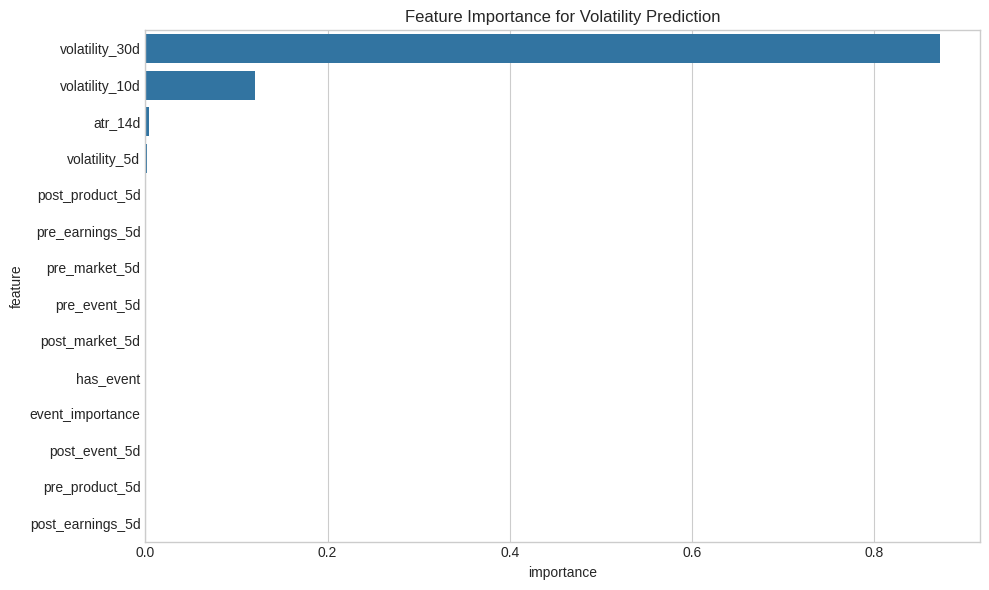

,feature,importance
2,volatility_30d,0.872411
1,volatility_10d,0.120575
3,atr_14d,0.004559
0,volatility_5d,0.001880
11,post_product_5d,0.000257
12,pre_earnings_5d,0.000143
8,pre_market_5d,0.000132
6,pre_event_5d,0.000031
9,post_market_5d,0.000011
4,has_event,0.000000


In [9]:
print("Analyzing feature importance...")
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance for Volatility Prediction')
plt.tight_layout()
plt.show()

feature_importance

Analyze event impact on volatility

Event Impact Summary:
    event_type  avg_vol_before  avg_vol_event  avg_vol_after  pct_change_after
0  Acquisition        0.189082       0.194133       0.194290          2.754739
1     Earnings        0.529183       0.565238       0.552045         10.650895
2       Market        0.603857       0.578902       0.625530         16.116798
3      Product        0.508186       0.427768       0.439336         -4.574853

Top 5 Events with Highest Volatility Increase:
   event_type                 description event_date  pct_change_after
75   Earnings  Quarterly Earnings 2014-01 2014-01-31        116.795452
99   Earnings  Quarterly Earnings 2020-01 2020-01-31         67.904612
79   Earnings  Quarterly Earnings 2015-01 2015-01-31         66.596299
84   Earnings  Quarterly Earnings 2016-04 2016-04-30         65.957978
68   Earnings  Quarterly Earnings 2012-04 2012-04-30         63.711386


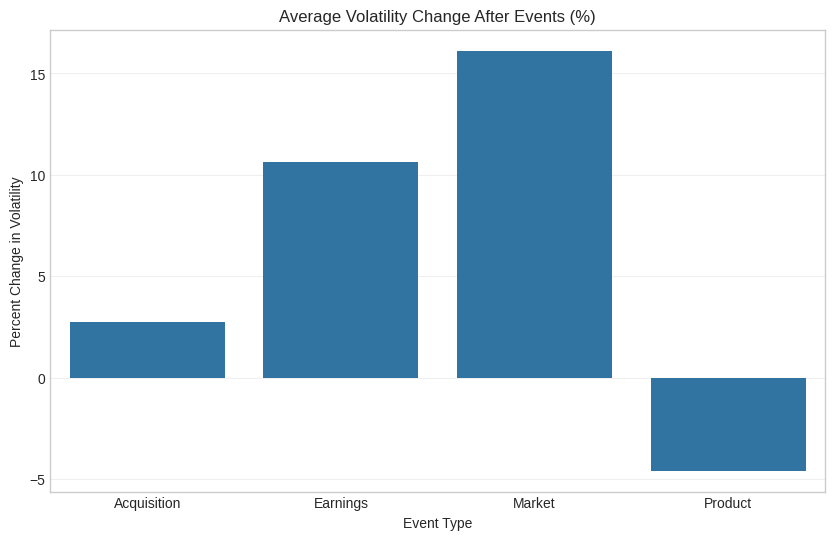

In [10]:
print("Analyze event impact on volatility")

# Calculate average volatility change before and after events
event_impact = pd.DataFrame({
    'event_type': pd.Series(dtype='str'),
    'event_date': pd.Series(dtype='datetime64[ns]'),
    'description': pd.Series(dtype='str'),
    'avg_vol_before': pd.Series(dtype='float'),
    'avg_vol_event': pd.Series(dtype='float'),
    'avg_vol_after': pd.Series(dtype='float'),
    'pct_change_after': pd.Series(dtype='float')
})

# event impact data
event_impacts = []
for event_type in ['Market', 'Product', 'Earnings', 'Acquisition']:
    type_events = events[events['event_type'] == event_type]
    
    for _, event in type_events.iterrows():
        event_date = event['date']
        
        before_mask = (df_integrated['date'] >= (event_date - timedelta(days=5))) & (df_integrated['date'] < event_date)
        event_mask = df_integrated['date'] == event_date
        after_mask = (df_integrated['date'] > event_date) & (df_integrated['date'] <= (event_date + timedelta(days=5)))
        
        avg_vol_before = df_integrated[before_mask]['volatility_20d'].mean()
        avg_vol_event = df_integrated[event_mask]['volatility_20d'].mean() if event_mask.any() else np.nan
        avg_vol_after = df_integrated[after_mask]['volatility_20d'].mean()
        
        pct_change = ((avg_vol_after - avg_vol_before) / avg_vol_before * 100) if avg_vol_before > 0 else np.nan
        
        event_impacts.append({
            'event_type': event_type,
            'event_date': event_date,
            'description': event['description'],
            'avg_vol_before': avg_vol_before,
            'avg_vol_event': avg_vol_event,
            'avg_vol_after': avg_vol_after,
            'pct_change_after': pct_change
        })

if event_impacts:
    event_impact = pd.concat([event_impact, pd.DataFrame(event_impacts)], ignore_index=True)

event_impact_summary = event_impact.groupby('event_type').agg({
    'avg_vol_before': 'mean',
    'avg_vol_event': 'mean',
    'avg_vol_after': 'mean',
    'pct_change_after': 'mean'
}).reset_index()

print("\nEvent Impact Summary:")
print(event_impact_summary)

print("\nTop 5 Events with Highest Volatility Increase:")
top_events = event_impact.sort_values('pct_change_after', ascending=False).head(5)
print(top_events[['event_type', 'description', 'event_date', 'pct_change_after']])

plt.figure(figsize=(10, 6))
sns.barplot(data=event_impact_summary, x='event_type', y='pct_change_after')
plt.title('Average Volatility Change After Events (%)')
plt.ylabel('Percent Change in Volatility')
plt.xlabel('Event Type')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:
print("Creating volatility predictions for future events...")

# Create sample future events
future_events = pd.DataFrame({
    'date': [
        pd.to_datetime('2025-05-01'), 
        pd.to_datetime('2025-07-20'), 
        pd.to_datetime('2025-10-15')
    ],
    'event_type': ['Earnings', 'Product', 'Earnings'],
    'description': [
        'Q1 2025 Earnings', 
        'Major AWS Expansion', 
        'Q3 2025 Earnings'
    ],
    'importance': [4, 5, 4]
})

# Average historical volatility patterns for each event type
def get_historical_patterns(event_type):
    """Extract volatility patterns around historical events of a specific type"""
    event_dates = df_integrated[
        (df_integrated['event_type'] == event_type) & 
        (~df_integrated['volatility_20d'].isna())
    ]['date'].tolist()
    
    all_patterns = []
    
    for event_date in event_dates:
        window_start = event_date - timedelta(days=5)
        window_end = event_date + timedelta(days=5)
        
        window_mask = (
            (df_integrated['date'] >= window_start) & 
            (df_integrated['date'] <= window_end)
        )
        
        window_data = df_integrated.loc[window_mask].copy()
        
        if len(window_data) > 0:
            pre_event_mask = window_data['date'] < event_date
            pre_event_vol = window_data.loc[pre_event_mask, 'volatility_20d'].mean()
            
            if not np.isnan(pre_event_vol) and pre_event_vol > 0:
                window_data['rel_volatility'] = window_data['volatility_20d'] / pre_event_vol
                window_data['day_rel'] = (window_data['date'] - event_date).dt.days
                
                all_patterns.append(window_data[['day_rel', 'rel_volatility']])
    
    if all_patterns:
        combined_patterns = pd.concat(all_patterns)
        avg_pattern = combined_patterns.groupby('day_rel')['rel_volatility'].mean().reset_index()
        return avg_pattern
    else:
        return None

# Historical patterns by event type
earnings_pattern = get_historical_patterns('Earnings')
product_pattern = get_historical_patterns('Product')
market_pattern = get_historical_patterns('Market')

def predict_volatility_for_event(event, current_volatility=0.2):
    """Predict volatility before and after an event"""
    if event['event_type'] == 'Earnings':
        pattern = earnings_pattern
    elif event['event_type'] == 'Product':
        pattern = product_pattern
    else:
        days = list(range(-5, 6))
        pattern = pd.DataFrame({
            'day_rel': days,
            'rel_volatility': [
                0.95 if d < -2 else
                0.98 if d < 0 else
                1.10 if d == 0 else
                1.05 if d < 3 else
                1.02 for d in days
            ]
        })
    
    days = list(range(-5, 6))
    prediction_df = pd.DataFrame(index=range(len(days)))
    
    for feature in features:
        prediction_df[feature] = 0
    
    # Current volatility measures as a baseline
    prediction_df['volatility_5d'] = current_volatility
    prediction_df['volatility_10d'] = current_volatility
    prediction_df['volatility_30d'] = current_volatility
    prediction_df['atr_14d'] = current_volatility * df_integrated['close'].mean() * 0.01  # Approx based on current data
    
    for i, day in enumerate(days):
        if day < 0:  # Before event
            prediction_df.loc[i, 'pre_event_5d'] = 1
            prediction_df.loc[i, f'pre_{event["event_type"].lower()}_5d'] = 1
        elif day == 0:  # Event day
            prediction_df.loc[i, 'has_event'] = 1
            prediction_df.loc[i, 'event_importance'] = event['importance']
        else:  # After event
            prediction_df.loc[i, 'post_event_5d'] = 1
            prediction_df.loc[i, f'post_{event["event_type"].lower()}_5d'] = 1
    
    # Model prediction
    base_predictions = model.predict(prediction_df[features])
    
    adjusted_predictions = []
    
    for i, day in enumerate(days):
        pattern_day = pattern['day_rel'].iloc[(pattern['day_rel'] - day).abs().argsort()[0]]
        pattern_value = pattern.loc[pattern['day_rel'] == pattern_day, 'rel_volatility'].values[0]
        
        # Historical pattern adjustment
        importance_factor = 1 + (event['importance'] - 3) * 0.1  
        
        # Blending model prediction with pattern
        pattern_weight = 0.6 if day >= 0 and day <= 2 else 0.3
        model_weight = 1 - pattern_weight
        
        adjusted_vol = (
            base_predictions[i] * model_weight + 
            current_volatility * pattern_value * importance_factor * pattern_weight
        )
        
        adjusted_predictions.append(adjusted_vol)
    
    results = pd.DataFrame({
        'day_relative_to_event': days,
        'predicted_volatility': adjusted_predictions
    })
    
    return results

# Predict volatility for each future event
all_predictions = []
for _, event in future_events.iterrows():
    current_vol = df_integrated.iloc[-30:]['volatility_20d'].mean()
    if np.isnan(current_vol):
        current_vol = 0.2  
    
    predictions = predict_volatility_for_event(event, current_volatility=current_vol)
    predictions['event_type'] = event['event_type']
    predictions['event_description'] = event['description']
    predictions['event_date'] = event['date']
    all_predictions.append(predictions)

future_volatility = pd.concat(all_predictions)

plt.figure(figsize=(12, 6))
for event_type in future_volatility['event_type'].unique():
    event_data = future_volatility[future_volatility['event_type'] == event_type].copy()
    plt.plot(event_data['day_relative_to_event'], event_data['predicted_volatility'], 
             marker='o', label=f"{event_type}")

plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Event Day')
plt.title('Predicted Volatility Around Future Events')
plt.xlabel('Days Relative to Event (0 = Event Day)')
plt.ylabel('Predicted Volatility')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nPredicted volatility around future events:")
print(future_volatility.head(20))